# 1. Import Libraries 

In [1]:
import glob
import time
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import altair as alt
pd.set_option('display.max_columns', None)

import cv2

import Utility_functions as ut
import Custom_Evaluation as ce

#PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms

#Skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring,ProgressBar, Checkpoint
from skorch.dataset import CVSplit, ValidSplit
from skorch.callbacks import TrainEndCheckpoint
from torch.utils.data import TensorDataset, DataLoader

#model performance
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay,top_k_accuracy_score, balanced_accuracy_score, f1_score, recall_score 

#Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

#Distnce Matrix
from scipy.spatial import distance_matrix, distance
from scipy.special import softmax

#Supress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

from sklearn.manifold import MDS, TSNE

import argparse
import optuna
from optuna.integration import SkorchPruningCallback

data_dir = 'C:/Dissertation/Data/'
kg_vec = 680

In [2]:
%load_ext autoreload
%autoreload 2

# 2. Import Data

In [3]:
Final_Images_df, predicate_df = ut.AWA2DataLoader(data_dir, data_type = "ResNet101-Features", 
                                                  Resnet101Type = 1, 
                                                  animal_attributes = 'Custom Animal Attribute KG', 
                                                  VectorType = 'Binary')

#data_type options
#1. "ResNet101-Features" to load Extracted Resnet101 features Avg. Time - 12 secs
#2. "Images"

#Resnet101Type
# 1 - Using Resnet Features provided with data
# 2 - Using Resnet Features extracted by Abhimanyu Acharya using a pretrainied Resnet101

# animal_attribute
#1. "AwA2" - As provided with AwA2 data
#2. "Custom Animal Attribute KG" - Custom KGs
#3. "Custom Animal Attribute + Taxonomy KG" - Custom KGs
#4. "Word2Vec" - word2vec-google-news-300
#5. "Dbnary" - Dbnary Knowledge Graph/Wiktionary (KGVec2Go Wiktionary/DBnary)
#6. "DBpedia" - DBPedia Knowledge Graph (KGVec2Go Classic RDF2vec: 500 walks, depth: 4, SG, 200 dimensions)

Using Resnet101 Features provided with data
Animal Attributes Included - Binary Vector
Custom KG Animal Attributes Included
Execution time: 8.691411256790161 seconds


# 3. Split Data in Predefined Test, Train & Validation for ZSL

In [4]:
trainval_df, TrainData01, ValData01, TrainData02, ValData02, TrainData03, ValData03, Seen_test_df, Unseen_test_df = ut.TestTrainValsplitdata_dir(data_dir, Final_Images_df)

  Training - Validation Split 01 
 Train Classes  
 Number of Classes 27 
 ['antelope' 'buffalo' 'chihuahua' 'collie' 'cow' 'elephant' 'fox'
 'german+shepherd' 'grizzly+bear' 'hippopotamus' 'humpback+whale'
 'killer+whale' 'lion' 'mouse' 'otter' 'persian+cat' 'pig' 'polar+bear'
 'rhinoceros' 'siamese+cat' 'skunk' 'spider+monkey' 'squirrel' 'tiger'
 'weasel' 'wolf' 'zebra'] 

 Validation Classes  
 Number of Classes 13 
 ['beaver' 'chimpanzee' 'dalmatian' 'deer' 'giant+panda' 'gorilla'
 'hamster' 'leopard' 'mole' 'moose' 'ox' 'rabbit' 'raccoon'] 

  Training - Validation Split 02 
 Train Classes  
 Number of Classes 27 
 ['buffalo' 'chimpanzee' 'collie' 'cow' 'deer' 'elephant' 'german+shepherd'
 'giant+panda' 'gorilla' 'hamster' 'hippopotamus' 'humpback+whale'
 'leopard' 'lion' 'mole' 'moose' 'mouse' 'polar+bear' 'rabbit' 'raccoon'
 'rhinoceros' 'siamese+cat' 'spider+monkey' 'squirrel' 'tiger' 'weasel'
 'wolf'] 

 Validation Classes  
 Number of Classes 13 
 ['antelope' 'beaver' 'chihua

# 4. Define Dependent and Independent variables 

In [5]:
# Pre defined Test split 01
X1 = TrainData01.iloc[:,1:2049]
y1 = TrainData01.iloc[:,-kg_vec:]

# Pre defined Test split 02
X2 = TrainData02.iloc[:,1:2049]
y2 = TrainData02.iloc[:,-kg_vec:]

# Pre defined Test split 03
X3 = TrainData03.iloc[:,1:2049]
y3 = TrainData03.iloc[:,-kg_vec:]

X_finaltrain = trainval_df.iloc[:,1:2049]
y_finaltrain = trainval_df.iloc[:,-kg_vec:]

In [6]:
#Train val split for testing projection network
X_train1,X_val_seen_classes1,y_train1,y_val_seen_classes1 = train_test_split(X1,y1,stratify=y1,test_size=0.1,random_state = 0)

X_train2,X_val_seen_classes2,y_train2,y_val_seen_classes2 = train_test_split(X2,y2,stratify=y2,test_size=0.1,random_state = 0)

X_train3,X_val_seen_classes3,y_train3,y_val_seen_classes3 = train_test_split(X3,y3,stratify=y3,test_size=0.1,random_state = 0)

#Stratify Final train data 
X_train_final,X_val_seen_classes_final,y_train_final,y_val_seen_classes_final = train_test_split(X_finaltrain,y_finaltrain,stratify=y_finaltrain,test_size=0.002,random_state = 0)

# 5. Define Animal Attributes

In [7]:
animal_attributes_df = pd.read_csv("C:/Dissertation/Data/AwA2-data/Animals_with_Attributes2/predicates.txt", sep = '\t',header = None, names = ['predicates'])
animal_attributes_list = animal_attributes_df['predicates'].tolist()
print(animal_attributes_list)

['black', 'white', 'blue', 'brown', 'gray', 'orange', 'red', 'yellow', 'patches', 'spots', 'stripes', 'furry', 'hairless', 'toughskin', 'big', 'small', 'bulbous', 'lean', 'flippers', 'hands', 'hooves', 'pads', 'paws', 'longleg', 'longneck', 'tail', 'chewteeth', 'meatteeth', 'buckteeth', 'strainteeth', 'horns', 'claws', 'tusks', 'smelly', 'flys', 'hops', 'swims', 'tunnels', 'walks', 'fast', 'slow', 'strong', 'weak', 'muscle', 'bipedal', 'quadrapedal', 'active', 'inactive', 'nocturnal', 'hibernate', 'agility', 'fish', 'meat', 'plankton', 'vegetation', 'insects', 'forager', 'grazer', 'hunter', 'scavenger', 'skimmer', 'stalker', 'newworld', 'oldworld', 'arctic', 'coastal', 'desert', 'bush', 'plains', 'forest', 'fields', 'jungle', 'mountains', 'ocean', 'ground', 'water', 'tree', 'cave', 'fierce', 'timid', 'smart', 'group', 'solitary', 'nestspot', 'domestic']


# 6. Load Taxonomy Information

In [8]:
taxonomy_df = pd.read_csv("C:/Dissertation/Data/Mammal Taxonomy/Mammal Taxonomy_noduplicates.csv")
taxonomy_df.drop(['subgenus','biogeographicRealm','CMW_sciName'], axis = 1, inplace = True)
taxonomy_df.head()

,sciName,animal_label,animal_class,mainCommonName,otherCommonNames,class,infraclass,magnorder,superorder,order,suborder,infraorder,parvorder,superfamily,family,subfamily,tribe,genus
0,Antilope_cervicapra,1,antelope,Blackbuck,Indian Antelope,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,RUMINANTIA,PECORA,NaN,NaN,BOVIDAE,ANTILOPINAE,ANTILOPINI,Antilope
1,Ursus_arctos,2,grizzly+bear,Brown Bear,Grizzly Bear|Kodiak Bear,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,ARCTOIDEA,NaN,URSOIDEA,URSIDAE,URSINAE,NaN,Ursus
2,Orcinus_orca,3,killer+whale,Killer Whale,Orca,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,ARTIODACTYLA,WHIPPOMORPHA,CETACEA,ODONTOCETI,DELPHINOIDEA,DELPHINIDAE,INCERTAE SEDIS,NaN,Orcinus
3,Aplodontia_rufa,4,beaver,Mountain Beaver,Boomer|Sewellel|Point Arena Mountain Beaver|Po...,Mammalia,Placentalia,Boreoeutheria,Euarchontoglires,RODENTIA,SCIUROMORPHA,NaN,NaN,NaN,APLODONTIIDAE,NaN,NaN,Aplodontia
4,Canis_familiaris,5,dalmatian,Domestic Dog,Dog|Dingo|Feral Dog|New Guinea Singing Dog|Vil...,Mammalia,Placentalia,Boreoeutheria,Laurasiatheria,CARNIVORA,CANIFORMIA,CANOIDEA,NaN,NaN,CANIDAE,NaN,NaN,Canis


# 7. Set up Neural Network for multilabel classifciation

### 7.1 Define DNN for projection network

In [9]:
class ProjectionNetwork1(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork1, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out   

In [10]:
class ProjectionNetwork2(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork2, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out   

In [11]:
class ProjectionNetwork3(nn.Module):
    def __init__(self, num_units, non_linear,dropout):
        super(ProjectionNetwork3, self).__init__()        
        self.fc1 = nn.Linear(2048, num_units)  
        self.fc2 = nn.Linear(num_units, num_units) 
        self.fc3 = nn.Linear(num_units, num_units) 
        self.fc4 = nn.Linear(num_units, kg_vec) 
        self.nonlinear = non_linear  
        self.dropout = nn.Dropout(dropout)
                        
    def forward(self, x):
        out = self.fc1(x)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.nonlinear(out)
        out = self.dropout(out)
        out = self.fc4(out)
        return out   

### 7.2 Define evaluation criterea and checkpoint for projection network

In [12]:
# Create Skorch EPOCHScoring   
train_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'train_recall_macro', on_train = True)
valid_macro_recall_score = EpochScoring(scoring='recall_macro', lower_is_better=False, name = 'valid_recall_macro', on_train = False)

# Create Checkpoint
CP1 = Checkpoint(monitor='valid_loss_best',dirname='exp1')
CP2 = Checkpoint(monitor='valid_loss_best',dirname='exp2')
CP3= Checkpoint(monitor='valid_loss_best',dirname='exp3')
CP_final= Checkpoint(monitor='valid_loss_best',dirname='exp_final')

### 7.3 Check for GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.empty_cache()
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA GeForce RTX 3060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### 7.4 Define Conventiona Zero Shot Leaning Function

In [14]:
def CZSL(mode, split, DNN, epochs, bs, numunits, lr, optimiser, dropout, mom, wd, device, checkpoint, pred_type, dist_type):
    torch.manual_seed(0)    
    
    if mode == "Train":
        if split == 1:
            X = X_train1.astype(np.float32).values
            y = y_train1.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes1
            SeenClassAttributes = y_val_seen_classes1
            UnseenData = ValData01
            
        if split == 2:
            X = X_train2.astype(np.float32).values
            y = y_train2.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes2
            SeenClassAttributes = y_val_seen_classes2
            UnseenData = ValData02
            
        if split == 3:
            X = X_train3.astype(np.float32).values
            y = y_train3.astype(np.float32).values
            SeenClassFeatures = X_val_seen_classes3
            SeenClassAttributes = y_val_seen_classes3
            UnseenData = ValData03
       
        
    if mode == "Test":
        X = X_train_final.astype(np.float32).values
        y = y_train_final.astype(np.float32).values        
        UnseenData = Unseen_test_df
    
    #Model 01
    net = NeuralNetClassifier(
    DNN,
    batch_size= bs,
    module__num_units = numunits,
    module__non_linear = optimiser,
    module__dropout = dropout,
    max_epochs=epochs,
    lr=lr,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = wd,
    train_split = ValidSplit(5),
    callbacks=[train_macro_recall_score,valid_macro_recall_score, checkpoint],
    callbacks__valid_acc=None,
    device= device
    )     
    
    #Train three models of three Train Val spilts
    print('Training DNN')
    st = time.time()   
    net.fit(X,y)
    et = time.time()
    elapsed_time = et - st
    print('Execution time:', elapsed_time, 'seconds')
    
    #Plot training val curves
    print('Training Validation Loss Curve')
    train_loss = net.history[:, 'train_loss']
    valid_loss = net.history[:, 'valid_loss']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('Error Loss', fontsize=10)
    plt.legend()
    plt.show() 
    
    print('Trianing Recall Macro Curve')
    train_loss = net.history[:, 'train_recall_macro']
    valid_loss = net.history[:, 'valid_recall_macro']
    plt.figure(figsize=(10,5))
    plt.plot(train_loss, 'o-', label='training')
    plt.plot(valid_loss, 'o-', label='validation')
    plt.xlabel('Number of Epochs', fontsize=10)
    plt.ylabel('F1 Score (Macro)', fontsize=10)
    plt.legend()
    plt.show() 
    
    #load best model weights
    net.load_params(checkpoint=checkpoint)  
 
    #predict attributes for Seen classes
    if mode == "Train":
        predicted_attributes = net.predict(SeenClassFeatures.astype(np.float32).values)
        #print attribute prediction DNN performance
        #print(classification_report(SeenClassAttributes.astype(np.float32).values, predicted_attributes, target_names=animal_attributes_list))    
        
        print("Recall (Macro)")
        print(recall_score(SeenClassAttributes.astype(np.float32).values, predicted_attributes, average='macro'))
    
    if mode == "Test":
        pass

    #predict attributes for Unseen classes 
    y_pred_unseen = net.predict(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    y_pred_unseen_proba = net.predict_proba(UnseenData.iloc[:,1:2049].astype(np.float32).values)
    
    #limit search space to unseen classes 
    predicatedf_CZSL = predicate_df[predicate_df['classes'].isin((UnseenData.classes.unique()).tolist())]
    animal_attributes = np.array(predicatedf_CZSL.iloc[:,-kg_vec:])
    animal_attributes_labels = predicatedf_CZSL['labels'].unique()
    print('Unseen Class Labels')
    print(animal_attributes_labels)
    
    #Spatialise the unseen classes using TSNE
    print('TSNE spatialisation of Unseen Classes')
    
    classes_df = predicatedf_CZSL.copy()
    classes_df.reset_index(inplace=True)
    
    embeddings = TSNE(n_components=2, verbose=0, random_state=123, perplexity=9.0)

    TSNE_predicates = embeddings.fit_transform(animal_attributes) 
    TSNE_predicates_df = pd.DataFrame(data = TSNE_predicates
                 , columns = ['Binary comp-1', 'Binary comp-2'])
    
    TSNE_predicates_df1 = pd.concat([TSNE_predicates_df,classes_df['classes']], axis = 1)
    TSNE_predicates_df1 = TSNE_predicates_df1.merge(taxonomy_df, how = 'inner', left_on = 'classes', right_on = 'animal_class')
    
    #By animal class
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('classes:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='classes:N'
    )

    display(binary_points.interactive() + text1)
    
    #By Taxonomy Family
    binary_points = alt.Chart(TSNE_predicates_df1).mark_circle(size=200).encode(
    x='Binary comp-1:Q',
    y='Binary comp-2:Q',
    color=alt.Color('order:N', scale=alt.Scale(scheme='Magma')),
    ).properties(
    width=800,
    height=800
    )

    text1 = binary_points.mark_text(
        align='left',
        baseline='middle',
        dx=7
    ).encode(
        text='order:N'
    )

    display(binary_points.interactive() + text1)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseenprob = []
    for y in y_pred_unseen_proba:
        y_pred_unseenprob.append(y[1])
        
    if pred_type == 'Probabilistic':
        dist_CZSL= (1-distance.cdist(y_pred_unseenprob, animal_attributes, dist_type))
    elif pred_type == 'Deterministic':    
        dist_CZSL= (1-distance.cdist(y_pred_unseen, animal_attributes, dist_type))
        
    CZSL_label_prediction = np.array([np.argmax(output) for output in dist_CZSL])
    
    #replace predicted labels with unseen class labels 
    if mode == "Train":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9, CZSL_label_prediction == 10, CZSL_label_prediction == 11
          , CZSL_label_prediction == 12], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]
          , animal_attributes_labels[10], animal_attributes_labels[11], animal_attributes_labels[12]], CZSL_label_prediction)
    
    if mode == "Test":
        CZSL_label_prediction = np.select([CZSL_label_prediction == 0, CZSL_label_prediction == 1, CZSL_label_prediction == 2, CZSL_label_prediction == 3
          , CZSL_label_prediction == 4, CZSL_label_prediction == 5, CZSL_label_prediction == 6, CZSL_label_prediction == 7
          , CZSL_label_prediction == 8, CZSL_label_prediction == 9], [animal_attributes_labels[0], animal_attributes_labels[1], animal_attributes_labels[2]
          , animal_attributes_labels[3], animal_attributes_labels[4], animal_attributes_labels[5]
          , animal_attributes_labels[6], animal_attributes_labels[7], animal_attributes_labels[8], animal_attributes_labels[9]], CZSL_label_prediction)
        
     #sort class names 
    class_labels = UnseenData[['labels','classes', 'order', 'family']]
    class_labels.sort_values(by=['labels'], inplace=True)
    animal_classes = class_labels['classes'].unique()
    
    #Assess CZSL Model performance
    print(classification_report(UnseenData['labels'], CZSL_label_prediction, target_names = animal_classes))

    cm = confusion_matrix(UnseenData['labels'], CZSL_label_prediction)
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(animal_classes)
    a.set_xticklabels(animal_classes)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    #predict taxonomy
    predicted_taxonomy_df = pd.DataFrame(CZSL_label_prediction, columns = ['pred_labels'])
    predicted_taxonomy_df = pd.merge(predicted_taxonomy_df, taxonomy_df,  how = 'left', left_on = 'pred_labels' , right_on = 'animal_label' )
    
    Train_family_labels = UnseenData.copy()
    Train_family_labels.sort_values(by=['order'], inplace=True)
    train_animal_family = Train_family_labels['order'].unique()
    
    print(classification_report(UnseenData['order'], predicted_taxonomy_df['order'], target_names=train_animal_family))
    
    cm = confusion_matrix(UnseenData['order'], predicted_taxonomy_df['order'])
    correct_predictions_perc = cm.diagonal()/cm.sum(axis=1)
    print("Top_1_accuracy for UnSeen Validation split 01 per class - " , correct_predictions_perc)
    print("Top_1_accuracy for UnSeen Validation split 01 - " , np.mean(correct_predictions_perc))

    # Visualize it as a heatmap
    plt.figure(figsize=(10,8))
    a = sns.heatmap(cm, annot=True, fmt='', cmap='Reds',annot_kws={"size": 10} )
    label_font = {'size':'10'}  # Adjust to fit
    a.set_xlabel('Predicted labels', fontdict=label_font);
    a.set_ylabel('Observed labels', fontdict=label_font);
    a.set_yticklabels(train_animal_family)
    a.set_xticklabels(train_animal_family)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=90) 
    plt.show()
    
    if mode == "Train":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = True)
    if mode == "Test":
        ce.per_class_top_k_accuracy_score(dist_CZSL, animal_attributes_labels, UnseenData, animal_classes, Train = False)
        
    return dist_CZSL, animal_attributes_labels, animal_classes    

# 8. Train Model

### 8.1 Train Validation Split 01

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4464                0.5262        0.4155                0.5383     +  5.4359
      2        0.3951                0.5588        0.3683                0.5843     +  2.5164
      3        0.3481                0.6040        0.3251                0.6254     +  2.2677
      4        0.3093                0.6426        0.2906                0.6615     +  2.0420
      5        0.2786                0.6765        0.2638                0.6915     +  2.2495
      6        0.2546                0.7045        0.2428                0.7170     +  2.2007
      7        0.2353                0.7282        0.2255                0.7383     +  2.0908
      8        0.2194                0.7474        0.2108                0.7562     +  2.1832
      9        0.2056                0.7633    

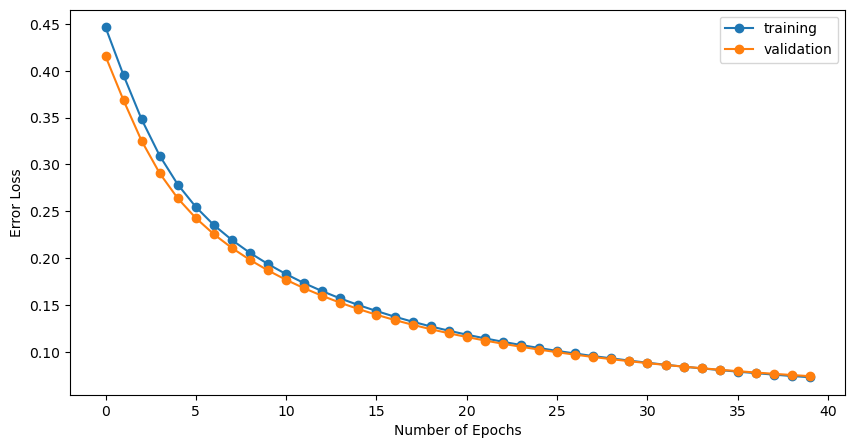

Trianing Recall Macro Curve


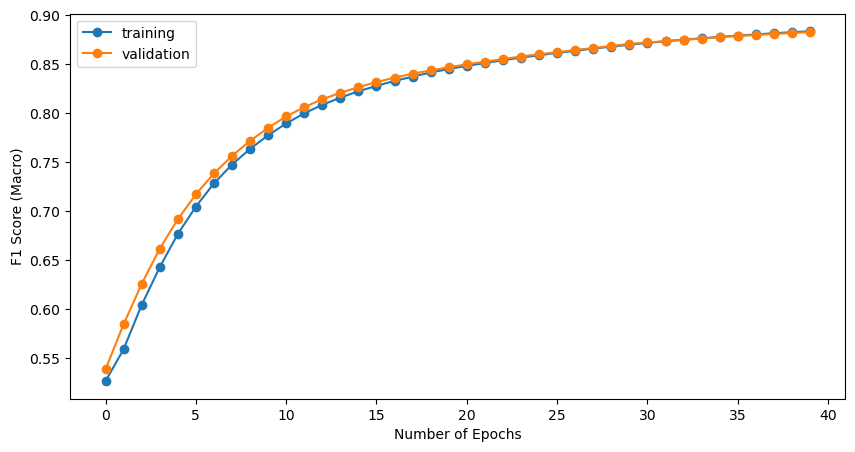

Recall (Macro)
0.8794746757554626
Unseen Class Labels
[ 4  5 12 15 16 20 21 25 26 29 39 40 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

      beaver       0.86      0.49      0.63       152
   dalmatian       0.54      0.30      0.39       442
        mole       0.02      0.19      0.03        75
     leopard       0.34      0.75      0.47       568
       moose       0.52      0.45      0.48       554
     gorilla       0.55      0.91      0.68       709
          ox       0.50      0.98      0.66       588
  chimpanzee       0.70      0.01      0.02       566
     hamster       0.66      0.75      0.70       640
      rabbit       0.11      0.01      0.01       877
 giant+panda       0.00      0.00      0.00       692
        deer       0.79      0.75      0.77      1069
     raccoon       0.43      0.19      0.27       408

    accuracy                           0.48      7340
   macro avg       0.46      0.44      0.39      7340
weighted avg       0.47      0.48      0.42      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.49342105 0.298642

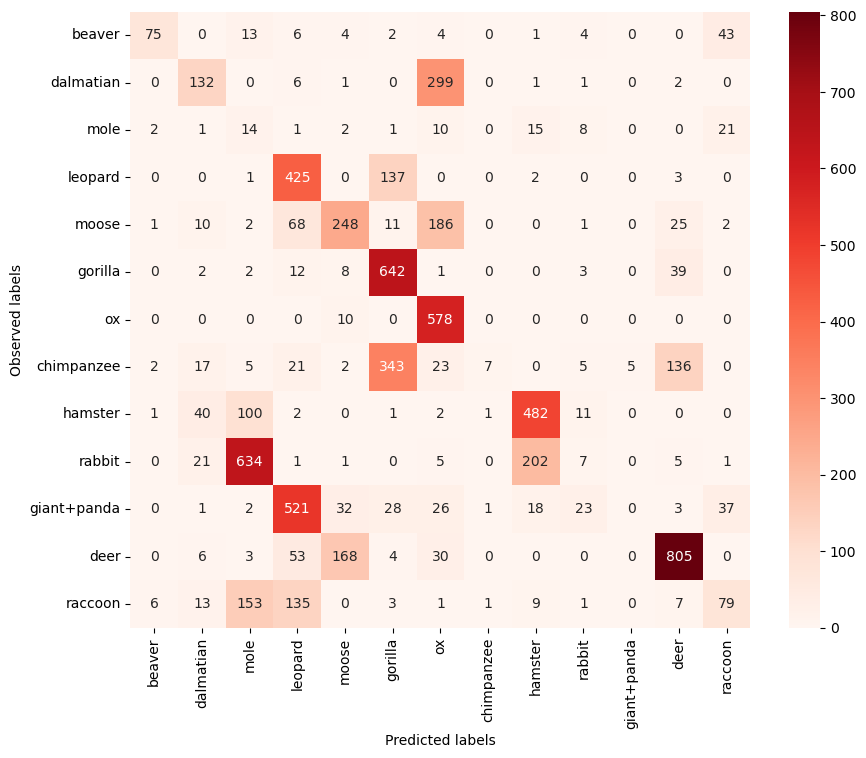

              precision    recall  f1-score   support

ARTIODACTYLA       0.77      0.93      0.84      2211
   CARNIVORA       0.80      0.64      0.71      2110
EULIPOTYPHLA       0.02      0.19      0.03        75
  LAGOMORPHA       0.11      0.01      0.01       877
    PRIMATES       0.84      0.78      0.81      1275
    RODENTIA       0.68      0.71      0.69       792

    accuracy                           0.68      7340
   macro avg       0.54      0.54      0.52      7340
weighted avg       0.70      0.68      0.68      7340

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.92718227 0.63933649 0.18666667 0.00798176 0.77803922 0.70580808]
Top_1_accuracy for UnSeen Validation split 01 -  0.5408357470840311


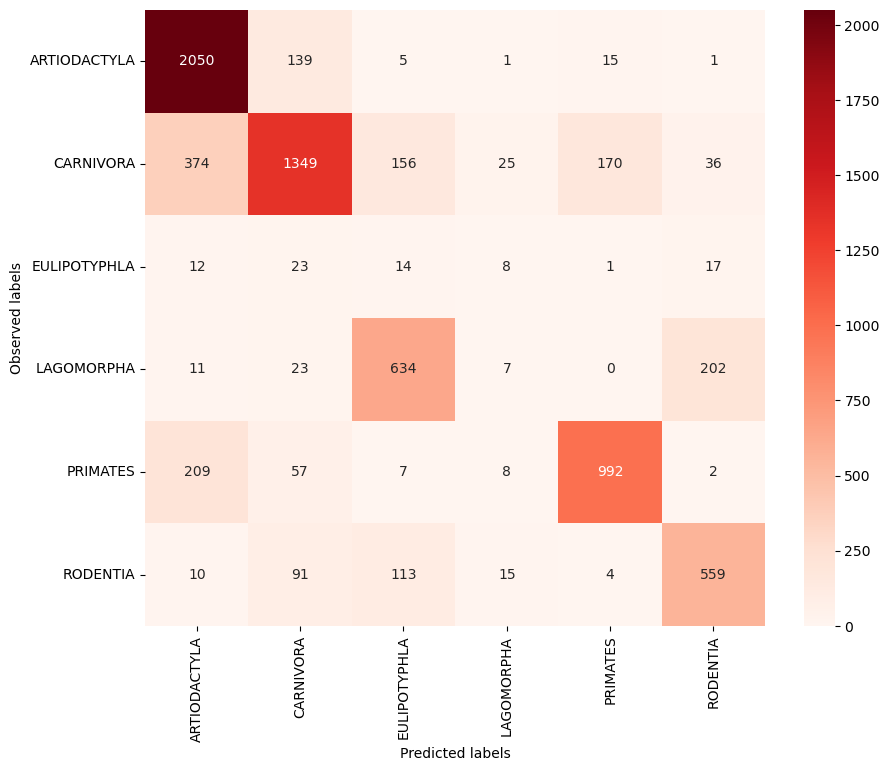

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6279189718772601 
              0         1
0        beaver  0.657895
1     dalmatian  0.527149
2          mole  0.346667
3       leopard  0.973592
4         moose  0.817690
5       gorilla  0.988717
6            ox  1.000000
7    chimpanzee  0.206714
8       hamster  0.964063
9        rabbit  0.119726
10  giant+panda  0.000000
11         deer  0.898971
12      raccoon  0.661765 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7525669445059547 
              0         1
0        beaver  0.710526
1     dalmatian  0.608597
2          mole  0.600000
3       leopard  0.980634
4         moose  0.895307
5       gorilla  0.992948
6            ox  1.000000
7    chimpanzee  0.664311
8       hamster  0.985938
9        rabbit  0.502851
10  giant+panda  0.000000
11         deer  0.967259
12      raccoon  0.875000 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8296237840448684 
              0         1
0        beaver  0.743421
1     

In [15]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 40, 
               bs = 8, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 8.2 Train Validation Split 02

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4416                0.5245        0.4121                0.5358     +  2.4489
      2        0.3929                0.5516        0.3673                0.5735     +  2.3842
      3        0.3461                0.5950        0.3233                0.6151     +  2.6450
      4        0.3061                0.6332        0.2877                0.6498     +  2.1101
      5        0.2750                0.6663        0.2602                0.6807     +  2.2007
      6        0.2505                0.6954        0.2381                0.7085     +  2.0790
      7        0.2303                0.7220        0.2196                0.7352     +  2.1018
      8        0.2134                0.7476        0.2040                0.7606     +  2.0841
      9        0.1987                0.7697    

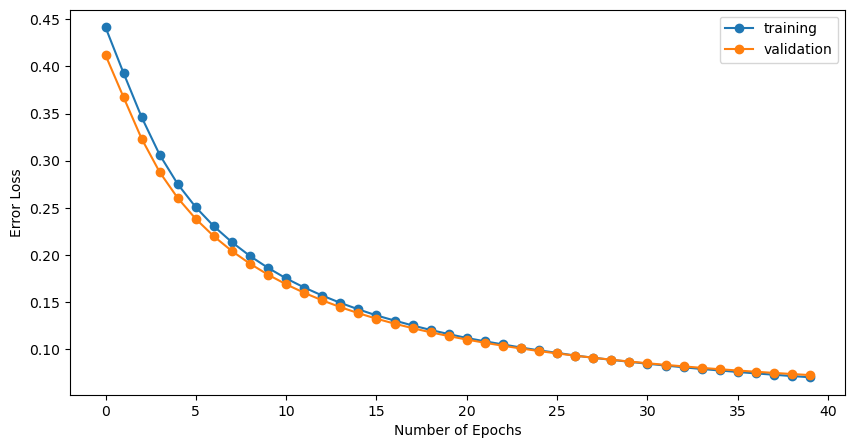

Trianing Recall Macro Curve


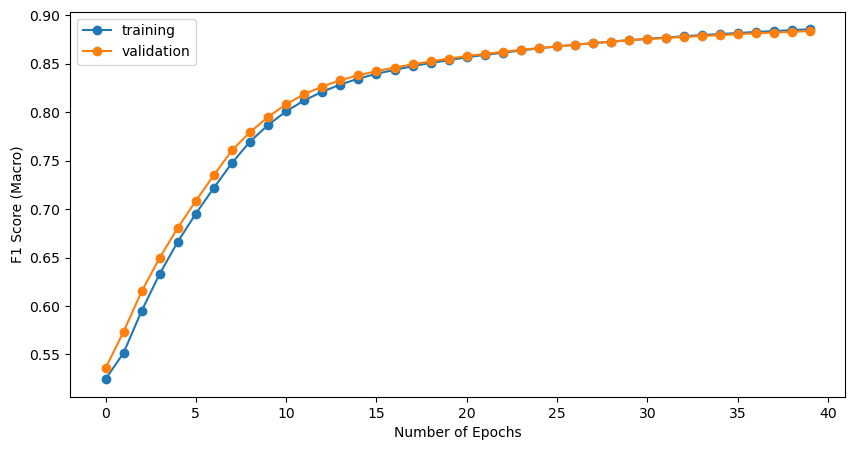

Recall (Macro)
0.8806431866633475
Unseen Class Labels
[ 1  2  3  4  5  6 11 21 22 33 36 38 42]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

    antelope       0.52      0.02      0.03       864
grizzly+bear       0.91      0.59      0.72       690
killer+whale       0.80      0.77      0.78       231
      beaver       0.00      0.00      0.00       152
   dalmatian       0.14      0.24      0.18       442
 persian+cat       0.27      0.02      0.04       599
       skunk       0.07      0.10      0.08       157
          ox       0.41      1.00      0.59       588
         fox       0.37      0.95      0.53       540
   chihuahua       0.45      0.18      0.25       448
       otter       0.88      0.03      0.05       592
       zebra       0.45      0.92      0.60       942
         pig       0.13      0.04      0.06       558

    accuracy                           0.41      6803
   macro avg       0.42      0.37      0.30      6803
weighted avg       0.47      0.41      0.32      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.0150463  0.592753

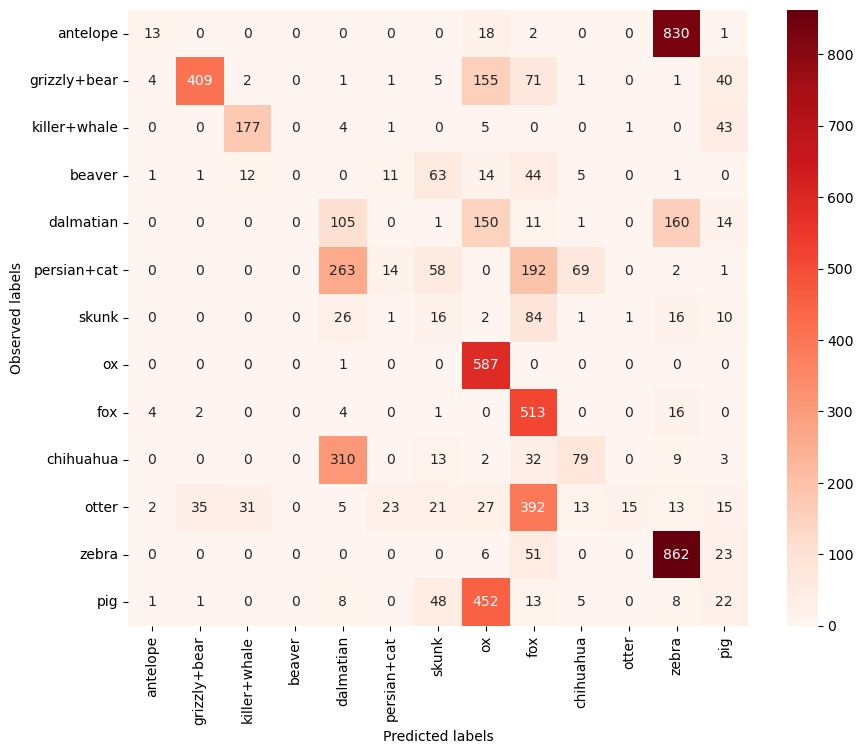

                precision    recall  f1-score   support

  ARTIODACTYLA       0.72      0.59      0.65      2241
     CARNIVORA       0.92      0.80      0.86      3468
PERISSODACTYLA       0.45      0.92      0.60       942
      RODENTIA       0.00      0.00      0.00       152

      accuracy                           0.73      6803
     macro avg       0.52      0.58      0.53      6803
  weighted avg       0.77      0.73      0.73      6803

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.58857653 0.80420992 0.91507431 0.        ]
Top_1_accuracy for UnSeen Validation split 01 -  0.5769651893940388


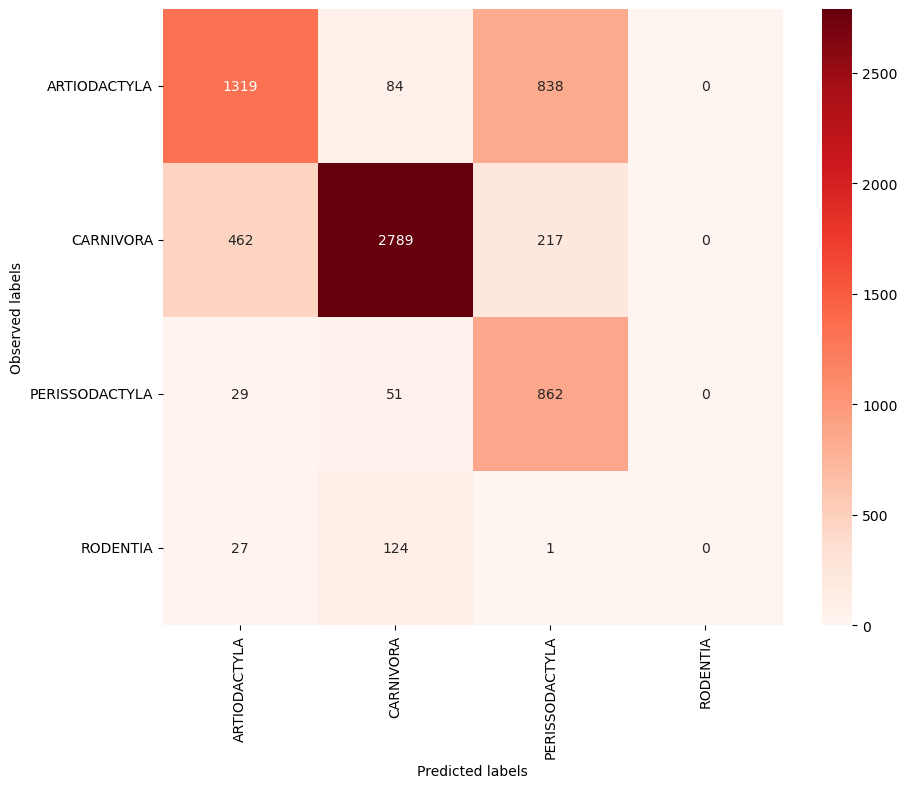

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6289055418655978 
               0         1
0       antelope  0.968750
1   grizzly+bear  0.715942
2   killer+whale  0.831169
3         beaver  0.000000
4      dalmatian  0.352941
5    persian+cat  0.217028
6          skunk  0.331210
7             ox  1.000000
8            fox  0.970370
9      chihuahua  0.763393
10         otter  0.263514
11         zebra  0.987261
12           pig  0.774194 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7266828299699034 
               0         1
0       antelope  0.980324
1   grizzly+bear  0.840580
2   killer+whale  0.909091
3         beaver  0.006579
4      dalmatian  0.416290
5    persian+cat  0.527546
6          skunk  0.471338
7             ox  1.000000
8            fox  0.994444
9      chihuahua  0.870536
10         otter  0.528716
11         zebra  1.000000
12           pig  0.901434 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8159022655133927 
               0         1
0  

In [16]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 40, 
               bs = 8,  
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

### 8.3 Train Validation Split 03

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4425                0.5276        0.4117                0.5398     +  2.2222
      2        0.3917                0.5558        0.3641                0.5792     +  2.2605
      3        0.3434                0.6022        0.3187                0.6240     +  2.1060
      4        0.3037                0.6405        0.2840                0.6569     +  2.0916
      5        0.2733                0.6713        0.2570                0.6859     +  2.1405
      6        0.2490                0.6974        0.2348                0.7101     +  2.2984
      7        0.2283                0.7216        0.2159                0.7327     +  2.1000
      8        0.2109                0.7436        0.1997                0.7539     +  2.0320
      9        0.1957                0.7629    

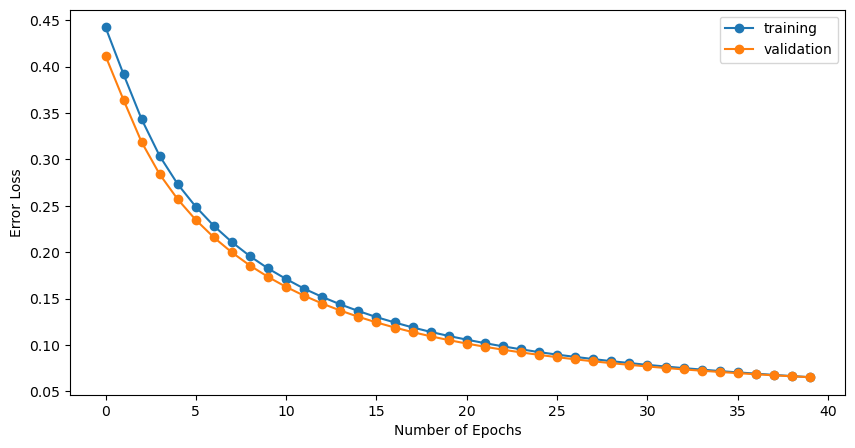

Trianing Recall Macro Curve


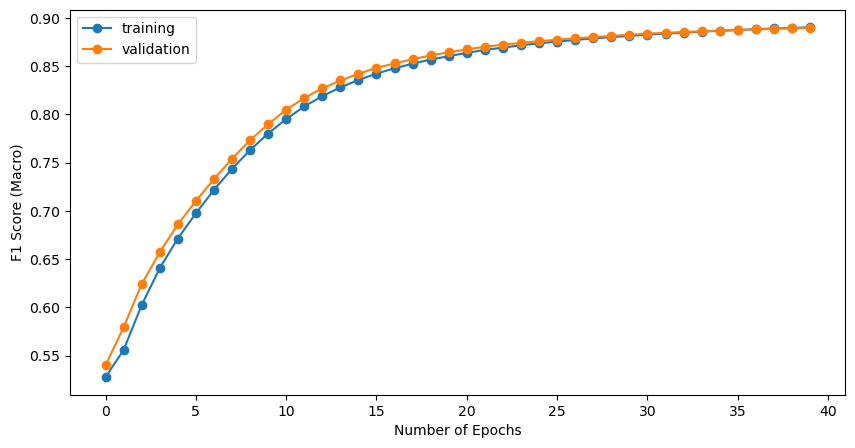

Recall (Macro)
0.8846569477875496
Unseen Class Labels
[10 16 18 25 27 28 29 32 33 35 39 42 48]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

                precision    recall  f1-score   support

   siamese+cat       0.10      0.15      0.12       400
         moose       0.58      0.50      0.54       554
humpback+whale       0.98      0.97      0.98       565
    chimpanzee       0.79      0.91      0.84       566
      squirrel       0.45      0.55      0.50       961
    rhinoceros       0.73      0.71      0.72       561
        rabbit       0.45      0.64      0.53       877
          wolf       0.34      0.83      0.48       470
     chihuahua       0.06      0.04      0.05       448
        weasel       0.15      0.01      0.02       222
   giant+panda       0.00      0.00      0.00       692
           pig       0.40      0.30      0.35       558
       raccoon       0.28      0.06      0.10       408

      accuracy                           0.48      7282
     macro avg       0.41      0.44      0.40      7282
  weighted avg       0.43      0.48      0.44      7282

Top_1_accuracy for UnSeen Validation split 01

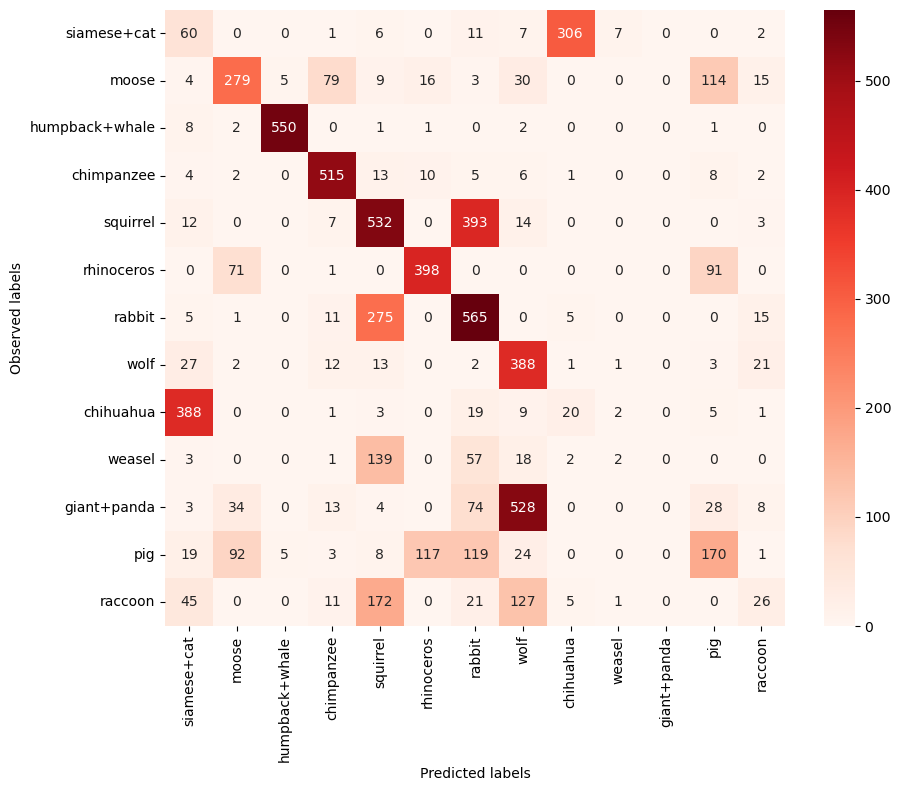

                precision    recall  f1-score   support

  ARTIODACTYLA       0.83      0.73      0.78      1677
     CARNIVORA       0.92      0.76      0.83      2640
    LAGOMORPHA       0.45      0.64      0.53       877
PERISSODACTYLA       0.73      0.71      0.72       561
      PRIMATES       0.79      0.91      0.84       566
      RODENTIA       0.45      0.55      0.50       961

      accuracy                           0.72      7282
     macro avg       0.70      0.72      0.70      7282
  weighted avg       0.76      0.72      0.73      7282

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.72629696 0.76060606 0.64424173 0.70944742 0.90989399 0.55359001]
Top_1_accuracy for UnSeen Validation split 01 -  0.7173460285518195


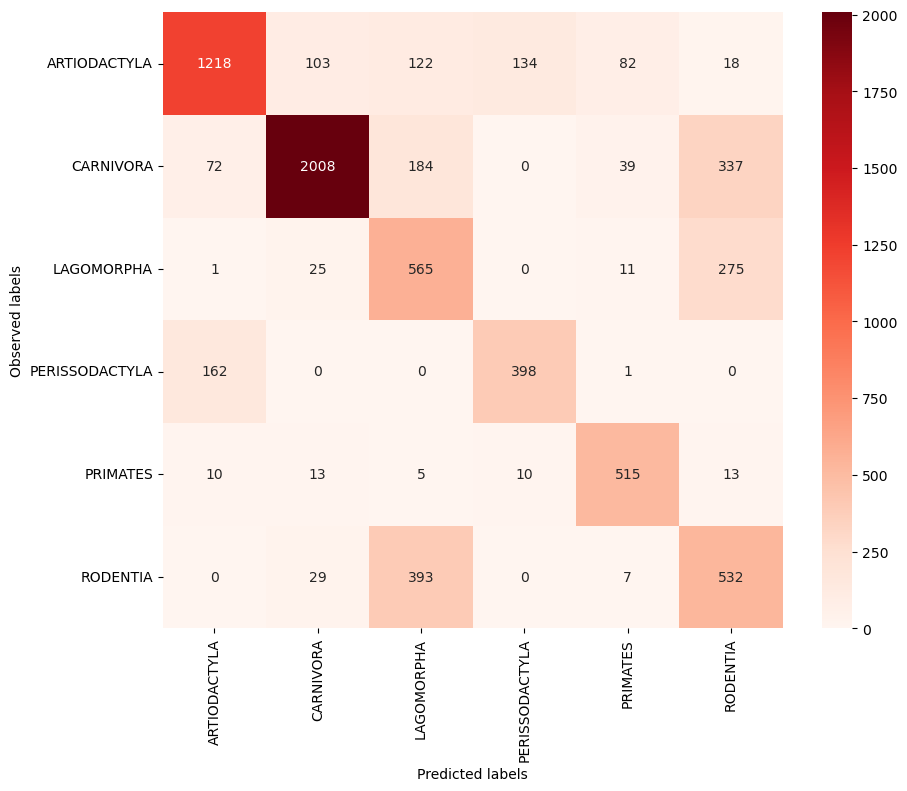

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6968571816731809 
                 0         1
0      siamese+cat  0.932500
1            moose  0.752708
2   humpback+whale  0.984071
3       chimpanzee  0.948763
4         squirrel  0.984391
5       rhinoceros  0.846702
6           rabbit  0.879133
7             wolf  0.904255
8        chihuahua  0.738839
9           weasel  0.126126
10     giant+panda  0.000000
11             pig  0.537634
12         raccoon  0.424020 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7978147463901166 
                 0         1
0      siamese+cat  0.962500
1            moose  0.848375
2   humpback+whale  0.991150
3       chimpanzee  0.961131
4         squirrel  0.990635
5       rhinoceros  0.998217
6           rabbit  0.948689
7             wolf  0.946809
8        chihuahua  0.841518
9           weasel  0.472973
10     giant+panda  0.002890
11             pig  0.720430
12         raccoon  0.686275 

 Top- 4  Accuracy per class 
 Top- 4  Accura

In [17]:
Train03 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 40, 
               bs = 8, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 2

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

# 9. Hyperoptimisation

In [25]:
import argparse
import optuna
from optuna.integration import SkorchPruningCallback

class ProjectionNetwork_hyper(nn.Module):
    def __init__(self, trial: optuna.Trial):
        super(ProjectionNetwork_hyper, self).__init__()        
        layers = []
        n_layers = trial.suggest_int("n_layers", 1, 3)
        dropout = trial.suggest_float("dropout", 0.1, 0.5)
        input_dim = 2048
        for i in range(n_layers):
            output_dim = trial.suggest_int("n_units_l{}".format(i), 4, 2048, log=True)
            layers.append(nn.Linear(input_dim, output_dim))
            layers.append(nn.Dropout(dropout))
            layers.append(nn.ReLU())
            input_dim = output_dim
        
        layers.append(nn.Linear(input_dim, kg_vec))

        self.model = nn.Sequential(*layers)
        print(self.model)  
        
                        
    def forward(self, x):
        out = self.model(x)
        return out   
    

def objective(trial: optuna.Trial):
    learning_rate = trial.suggest_loguniform('lr', .001, 1)
    bs = trial.suggest_int("batch_size", 4, 64)
    ep = trial.suggest_int("max_epoch", 5, 50)
    mom = trial.suggest_loguniform('optimizer__momentum', .90, .99)
   
       
    hyper_net1 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net2 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    hyper_net3 = NeuralNetClassifier(
    ProjectionNetwork_hyper(trial),
    batch_size= bs,
    max_epochs=ep,
    lr=learning_rate,
    criterion = torch.nn.modules.loss.BCEWithLogitsLoss, # to use with Sigmoid 
    optimizer=torch.optim.SGD,
    optimizer__momentum = mom,
    optimizer__weight_decay = 0,
    train_split = ValidSplit(5),
    callbacks=[valid_macro_recall_score,SkorchPruningCallback(trial, 'valid_recall_macro')],
    callbacks__valid_acc=None,
    device='cuda'
    )        
    
    #Split 1
    X1= X_train1.astype(np.float32).values
    y1 = y_train1.astype(np.float32).values
    hyper_net1.fit(X1, y1)
    #predict attributes for Unseen classes 
    y_pred_unseen1 = hyper_net1.predict_proba(ValData01.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob1 = []
    for y in y_pred_unseen1:
        y_pred_unseen_prob1.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL1 = predicate_df[predicate_df['classes'].isin((ValData01.classes.unique()).tolist())]
    animal_attributes1 = np.array(predicatedf_CZSL1.iloc[:,-kg_vec:])
    animal_attributes_labels1 = predicatedf_CZSL1['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosine Distance           
    dist_CZSL1= (1-distance.cdist(y_pred_unseen_prob1, animal_attributes1, 'cosine'))        
    CZSL_label_prediction1 = np.array([np.argmax(output) for output in dist_CZSL1])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction1 = np.select([CZSL_label_prediction1 == 0, CZSL_label_prediction1 == 1, CZSL_label_prediction1 == 2, CZSL_label_prediction1 == 3
          , CZSL_label_prediction1 == 4, CZSL_label_prediction1 == 5, CZSL_label_prediction1 == 6, CZSL_label_prediction1 == 7
          , CZSL_label_prediction1 == 8, CZSL_label_prediction1 == 9, CZSL_label_prediction1 == 10, CZSL_label_prediction1 == 11
          , CZSL_label_prediction1 == 12], [animal_attributes_labels1[0], animal_attributes_labels1[1], animal_attributes_labels1[2]
          , animal_attributes_labels1[3], animal_attributes_labels1[4], animal_attributes_labels1[5]
          , animal_attributes_labels1[6], animal_attributes_labels1[7], animal_attributes_labels1[8], animal_attributes_labels1[9]
          , animal_attributes_labels1[10], animal_attributes_labels1[11], animal_attributes_labels1[12]], CZSL_label_prediction1)
        
    recall_score1 = recall_score(ValData01['labels'], CZSL_label_prediction1, average = 'macro')
    
    #Split 2
    X2= X_train2.astype(np.float32).values
    y2 = y_train2.astype(np.float32).values
    hyper_net2.fit(X2, y2)
    #predict attributes for Unseen classes 
    y_pred_unseen2 = hyper_net2.predict_proba(ValData02.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob2 = []
    for y in y_pred_unseen2:
        y_pred_unseen_prob2.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL2 = predicate_df[predicate_df['classes'].isin((ValData02.classes.unique()).tolist())]
    animal_attributes2 = np.array(predicatedf_CZSL2.iloc[:,-kg_vec:])
    animal_attributes_labels2 = predicatedf_CZSL2['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL2= (1-distance.cdist(y_pred_unseen_prob2, animal_attributes2, 'cosine'))        
    CZSL_label_prediction2 = np.array([np.argmax(output) for output in dist_CZSL2])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction2 = np.select([CZSL_label_prediction2 == 0, CZSL_label_prediction2 == 1, CZSL_label_prediction2 == 2, CZSL_label_prediction2 == 3
          , CZSL_label_prediction2 == 4, CZSL_label_prediction2 == 5, CZSL_label_prediction2 == 6, CZSL_label_prediction2 == 7
          , CZSL_label_prediction2 == 8, CZSL_label_prediction2 == 9, CZSL_label_prediction2 == 10, CZSL_label_prediction2 == 11
          , CZSL_label_prediction2 == 12], [animal_attributes_labels2[0], animal_attributes_labels2[1], animal_attributes_labels2[2]
          , animal_attributes_labels2[3], animal_attributes_labels2[4], animal_attributes_labels2[5]
          , animal_attributes_labels2[6], animal_attributes_labels2[7], animal_attributes_labels2[8], animal_attributes_labels2[9]
          , animal_attributes_labels2[10], animal_attributes_labels2[11], animal_attributes_labels2[12]], CZSL_label_prediction2)
        
    recall_score2 = recall_score(ValData02['labels'], CZSL_label_prediction2, average = 'macro')
   
    #Split 3
    X3= X_train3.astype(np.float32).values
    y3 = y_train3.astype(np.float32).values
    hyper_net3.fit(X3, y3)
    #predict attributes for Unseen classes 
    y_pred_unseen3 = hyper_net3.predict_proba(ValData03.iloc[:,1:2049].astype(np.float32).values)
    
    #assign classes to unseen data by assigning label from closest class using Cosing Distance
    y_pred_unseen_prob3 = []
    for y in y_pred_unseen3:
        y_pred_unseen_prob3.append(y[1])
       
    #limit search space to unseen classes 
    predicatedf_CZSL3 = predicate_df[predicate_df['classes'].isin((ValData03.classes.unique()).tolist())]
    animal_attributes3 = np.array(predicatedf_CZSL3.iloc[:,-kg_vec:])
    animal_attributes_labels3 = predicatedf_CZSL3['labels'].unique()
            
    #assign classes to unseen data by assigning label from closest class using Cosing Distance           
    dist_CZSL3= (1-distance.cdist(y_pred_unseen_prob3, animal_attributes3, 'cosine'))        
    CZSL_label_prediction3 = np.array([np.argmax(output) for output in dist_CZSL3])
    
    #replace predicted labels with unseen class labels 
    CZSL_label_prediction3 = np.select([CZSL_label_prediction3 == 0, CZSL_label_prediction3 == 1, CZSL_label_prediction3 == 2, CZSL_label_prediction3 == 3
          , CZSL_label_prediction3 == 4, CZSL_label_prediction3 == 5, CZSL_label_prediction3 == 6, CZSL_label_prediction3 == 7
          , CZSL_label_prediction3 == 8, CZSL_label_prediction3 == 9, CZSL_label_prediction3 == 10, CZSL_label_prediction3 == 11
          , CZSL_label_prediction3 == 12], [animal_attributes_labels3[0], animal_attributes_labels3[1], animal_attributes_labels3[2]
          , animal_attributes_labels3[3], animal_attributes_labels3[4], animal_attributes_labels3[5]
          , animal_attributes_labels3[6], animal_attributes_labels3[7], animal_attributes_labels3[8], animal_attributes_labels3[9]
          , animal_attributes_labels3[10], animal_attributes_labels3[11], animal_attributes_labels3[12]], CZSL_label_prediction3)
        
    recall_score3 = recall_score(ValData03['labels'], CZSL_label_prediction3, average = 'macro')
    
    results = [recall_score1,recall_score2,recall_score3]
    print(results)
    #hyper_net.set_params(verbose=0)

    return np.mean(results)

In [26]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="DNN with KG.")
    parser.add_argument(
        "--pruning",
        "-p",
        action="store_true",
        help="Activate the pruning feature. `MedianPruner` stops unpromising "
        "trials at the early stages of training.",
    )
    args, unknown = parser.parse_known_args()

    pruner = optuna.pruners.MedianPruner() if args.pruning else optuna.pruners.NopPruner()

    study = optuna.create_study(direction="maximize", pruner=pruner)
    study.optimize(objective, n_trials=100, timeout=1000)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-12-08 16:33:50,455] A new study created in memory with name: no-name-d13f6d7b-f7e3-43f9-86ae-2c8070d3fa2f


Sequential(
  (0): Linear(in_features=2048, out_features=124, bias=True)
  (1): Dropout(p=0.13895470308384988, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=124, out_features=10, bias=True)
  (4): Dropout(p=0.13895470308384988, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=217, bias=True)
  (7): Dropout(p=0.13895470308384988, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=217, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=124, bias=True)
  (1): Dropout(p=0.13895470308384988, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=124, out_features=10, bias=True)
  (4): Dropout(p=0.13895470308384988, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=217, bias=True)
  (7): Dropout(p=0.13895470308384988, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=217, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=124, bias=True)
  (1): Dropout(p=0.

[I 2022-12-08 16:35:57,893] Trial 0 finished with value: 0.3488686933109406 and parameters: {'lr': 0.05032807919966222, 'batch_size': 18, 'max_epoch': 22, 'optimizer__momentum': 0.9370330138719143, 'n_layers': 3, 'dropout': 0.13895470308384988, 'n_units_l0': 124, 'n_units_l1': 10, 'n_units_l2': 217}. Best is trial 0 with value: 0.3488686933109406.


[0.3870388012294088, 0.27647845064865234, 0.38308882805476074]
Sequential(
  (0): Linear(in_features=2048, out_features=4, bias=True)
  (1): Dropout(p=0.3196357436186275, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=4, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=4, bias=True)
  (1): Dropout(p=0.3196357436186275, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=4, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=4, bias=True)
  (1): Dropout(p=0.3196357436186275, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=4, out_features=680, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.7071        0.7032                0.4802  1.1457
      2        0.7004        0.6967                0.4877  1.1745
      3        0.6943        0.6905                0.4930  1.1431
      4        0

     27        0.5279        0.4975                0.5021  1.3777
     28        0.5173        0.4860                0.5042  1.2698


[I 2022-12-08 16:38:18,880] Trial 1 finished with value: 0.08762038114511574 and parameters: {'lr': 0.0013815049064995987, 'batch_size': 16, 'max_epoch': 28, 'optimizer__momentum': 0.9726932333819689, 'n_layers': 1, 'dropout': 0.3196357436186275, 'n_units_l0': 4}. Best is trial 0 with value: 0.3488686933109406.


[0.06894447950587325, 0.07692307692307693, 0.11699358700639707]
Sequential(
  (0): Linear(in_features=2048, out_features=19, bias=True)
  (1): Dropout(p=0.13302131676473683, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=19, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=19, bias=True)
  (1): Dropout(p=0.13302131676473683, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=19, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=19, bias=True)
  (1): Dropout(p=0.13302131676473683, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=19, out_features=680, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.6930        0.6889                0.4599  0.7705
      2        0.6878        0.6839                0.4687  0.8387
      3        0.6830        0.6780                0.4757  0.7306
      

     30        0.4439        0.4161                0.5381  0.7982
     31        0.4421        0.4146                0.5399  0.7597
     32        0.4401        0.4130                0.5414  0.8638
     33        0.4373        0.4114                0.5433  0.7623
     34        0.4377        0.4097                0.5446  0.7310
     35        0.4346        0.4081                0.5465  0.7358
     36        0.4336        0.4063                0.5483  0.7680
     37        0.4322        0.4046                0.5499  0.7670
     38        0.4298        0.4027                0.5518  0.7364
     39        0.4283        0.4009                0.5539  0.7877
     40        0.4258        0.3990                0.5560  0.7774
     41        0.4240        0.3970                0.5581  0.8053
     42        0.4223        0.3950                0.5603  0.8751
     43        0.4208        0.3930                0.5621  0.9708
     44        0.4182        0.3908                0.5645  0.8894
     45   

[I 2022-12-08 16:41:22,800] Trial 2 finished with value: 0.21606311614105 and parameters: {'lr': 0.00102460102976969, 'batch_size': 30, 'max_epoch': 50, 'optimizer__momentum': 0.9378073596448322, 'n_layers': 1, 'dropout': 0.13302131676473683, 'n_units_l0': 19}. Best is trial 0 with value: 0.3488686933109406.


[0.19804360166478854, 0.2319933540924956, 0.2181523926658658]
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.37255183222291255, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=23, bias=True)
  (4): Dropout(p=0.37255183222291255, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=23, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.37255183222291255, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=23, bias=True)
  (4): Dropout(p=0.37255183222291255, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=23, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.37255183222291255, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=23, bias=True)
  (4): Dropout(p=0.37255183222291255, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=23, 

     40        0.4749        0.4356                0.5230  0.6133
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.6938        0.6913                0.4532  0.6428
      2        0.6904        0.6882                0.4620  0.5598
      3        0.6872        0.6850                0.4692  0.5847
      4        0.6840        0.6816                0.4752  0.5601
      5        0.6806        0.6780                0.4833  0.5622
      6        0.6770        0.6740                0.4851  0.5867
      7        0.6730        0.6696                0.4890  0.5653
      8        0.6685        0.6646                0.4929  0.5714
      9        0.6635        0.6589                0.4969  0.5274
     10        0.6578        0.6520                0.5026  0.5637
     11        0.6508        0.6416                0.5065  0.5357
     12        0.6404        0.6245                0.5054  0.5609
     13   

[I 2022-12-08 16:43:20,998] Trial 3 finished with value: 0.08101553831035024 and parameters: {'lr': 0.0020389439861716826, 'batch_size': 51, 'max_epoch': 40, 'optimizer__momentum': 0.9618740505772895, 'n_layers': 2, 'dropout': 0.37255183222291255, 'n_units_l0': 7, 'n_units_l1': 23}. Best is trial 0 with value: 0.3488686933109406.


[0.08920046108489689, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=10, bias=True)
  (1): Dropout(p=0.1239514883137952, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=676, bias=True)
  (4): Dropout(p=0.1239514883137952, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=676, out_features=12, bias=True)
  (7): Dropout(p=0.1239514883137952, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=12, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=10, bias=True)
  (1): Dropout(p=0.1239514883137952, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=676, bias=True)
  (4): Dropout(p=0.1239514883137952, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=676, out_features=12, bias=True)
  (7): Dropout(p=0.1239514883137952, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=12, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=

[I 2022-12-08 16:44:15,768] Trial 4 finished with value: 0.07692307692307693 and parameters: {'lr': 0.6192610892467342, 'batch_size': 19, 'max_epoch': 9, 'optimizer__momentum': 0.960542101041478, 'n_layers': 3, 'dropout': 0.1239514883137952, 'n_units_l0': 10, 'n_units_l1': 676, 'n_units_l2': 12}. Best is trial 0 with value: 0.3488686933109406.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=870, bias=True)
  (1): Dropout(p=0.2737944858220831, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=870, out_features=13, bias=True)
  (4): Dropout(p=0.2737944858220831, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=13, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=870, bias=True)
  (1): Dropout(p=0.2737944858220831, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=870, out_features=13, bias=True)
  (4): Dropout(p=0.2737944858220831, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=13, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=870, bias=True)
  (1): Dropout(p=0.2737944858220831, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=870, out_features=13, bias=True)
  (4): Dropout(p=0.2737944858220831, inplace=False)
  (5): ReLU()
  (6): Linear(in_featu

[I 2022-12-08 16:45:20,725] Trial 5 finished with value: 0.2745767883971203 and parameters: {'lr': 0.02569025600950567, 'batch_size': 46, 'max_epoch': 20, 'optimizer__momentum': 0.9028133374848746, 'n_layers': 2, 'dropout': 0.2737944858220831, 'n_units_l0': 870, 'n_units_l1': 13}. Best is trial 0 with value: 0.3488686933109406.


[0.28633164294566177, 0.21460989539197686, 0.32278882685372223]
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.26087634023110073, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=6, out_features=4, bias=True)
  (4): Dropout(p=0.26087634023110073, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.26087634023110073, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=6, out_features=4, bias=True)
  (4): Dropout(p=0.26087634023110073, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=6, bias=True)
  (1): Dropout(p=0.26087634023110073, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=6, out_features=4, bias=True)
  (4): Dropout(p=0.26087634023110073, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=4, out_

     14        0.4876        0.4515                0.5199  0.8280
     15        0.4819        0.4462                0.5233  0.8504
     16        0.4789        0.4435                0.5249  0.8457
     17        0.4761        0.4396                0.5255  0.7494
     18        0.4735        0.4376                0.5265  0.7928
     19        0.4724        0.4365                0.5271  0.7805
     20        0.4709        0.4355                0.5273  0.8148
     21        0.4691        0.4343                0.5267  0.8034
     22        0.4676        0.4333                0.5257  0.8769
     23        0.4689        0.4327                0.5263  0.8356
     24        0.4671        0.4318                0.5264  0.7711
     25        0.4666        0.4307                0.5267  0.7836
     26        0.4650        0.4305                0.5269  0.7899
     27        0.4634        0.4292                0.5262  0.8464
     28        0.4649        0.4289                0.5261  0.8390
     29   

[I 2022-12-08 16:47:11,776] Trial 6 finished with value: 0.0883195081235308 and parameters: {'lr': 0.015470848797713613, 'batch_size': 38, 'max_epoch': 32, 'optimizer__momentum': 0.9446893154992578, 'n_layers': 2, 'dropout': 0.26087634023110073, 'n_units_l0': 6, 'n_units_l1': 4}. Best is trial 0 with value: 0.3488686933109406.


[0.11111237052443859, 0.07692307692307693, 0.07692307692307693]
Sequential(
  (0): Linear(in_features=2048, out_features=627, bias=True)
  (1): Dropout(p=0.2809510785718665, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=627, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=627, bias=True)
  (1): Dropout(p=0.2809510785718665, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=627, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=627, bias=True)
  (1): Dropout(p=0.2809510785718665, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=627, out_features=680, bias=True)
)
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.4609        0.3499                0.6067  0.8492
      2        0.3095        0.2503                0.7123  0.6123
      3        0.2357        0.1973                0.7739  0.6404
   

[I 2022-12-08 16:47:46,796] Trial 7 finished with value: 0.42557934683942494 and parameters: {'lr': 0.010697267529081726, 'batch_size': 35, 'max_epoch': 10, 'optimizer__momentum': 0.9522309113527292, 'n_layers': 1, 'dropout': 0.2809510785718665, 'n_units_l0': 627}. Best is trial 7 with value: 0.42557934683942494.


[0.4548893669164306, 0.37537720286932613, 0.446471470732518]
Sequential(
  (0): Linear(in_features=2048, out_features=14, bias=True)
  (1): Dropout(p=0.11342190908798089, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=14, out_features=64, bias=True)
  (4): Dropout(p=0.11342190908798089, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=673, bias=True)
  (7): Dropout(p=0.11342190908798089, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=673, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=14, bias=True)
  (1): Dropout(p=0.11342190908798089, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=14, out_features=64, bias=True)
  (4): Dropout(p=0.11342190908798089, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=673, bias=True)
  (7): Dropout(p=0.11342190908798089, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=673, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_featur

[I 2022-12-08 16:49:30,059] Trial 8 finished with value: 0.32183968945022046 and parameters: {'lr': 0.21935248153729803, 'batch_size': 35, 'max_epoch': 26, 'optimizer__momentum': 0.9698549629292559, 'n_layers': 3, 'dropout': 0.11342190908798089, 'n_units_l0': 14, 'n_units_l1': 64, 'n_units_l2': 673}. Best is trial 7 with value: 0.42557934683942494.


[0.3253447449141261, 0.3068480318917911, 0.3333262915447441]
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.4430876188414157, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=50, bias=True)
  (4): Dropout(p=0.4430876188414157, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=50, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.4430876188414157, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=50, bias=True)
  (4): Dropout(p=0.4430876188414157, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=50, out_features=680, bias=True)
)
Sequential(
  (0): Linear(in_features=2048, out_features=7, bias=True)
  (1): Dropout(p=0.4430876188414157, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=7, out_features=50, bias=True)
  (4): Dropout(p=0.4430876188414157, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=50, out_fea

     43        0.4323        0.4316                0.5162  0.8036
     44        0.4323        0.4316                0.5191  0.7897
     45        0.4323        0.4316                0.5176  0.6645
     46        0.4323        0.4316                0.5162  0.6538
     47        0.4323        0.4316                0.5162  0.6877
     48        0.4323        0.4316                0.5191  0.6420
     49        0.4323        0.4315                0.5162  0.6364
     50        0.4323        0.4316                0.5176  0.6331
  epoch    train_loss    valid_loss    valid_recall_macro     dur
-------  ------------  ------------  --------------------  ------
      1        0.4811        0.4342                0.5176  0.6301
      2        0.4361        0.4329                0.5250  0.6262
      3        0.4349        0.4327                0.5279  0.6130
      4        0.4346        0.4326                0.5265  0.6277
      5        0.4344        0.4326                0.5235  0.6074
      6   

[I 2022-12-08 16:52:07,813] Trial 9 finished with value: 0.07692307692307693 and parameters: {'lr': 0.6406921368704711, 'batch_size': 42, 'max_epoch': 50, 'optimizer__momentum': 0.986043164695683, 'n_layers': 2, 'dropout': 0.4430876188414157, 'n_units_l0': 7, 'n_units_l1': 50}. Best is trial 7 with value: 0.42557934683942494.


[0.07692307692307693, 0.07692307692307693, 0.07692307692307693]
Number of finished trials: 10
Best trial:
  Value: 0.42557934683942494
  Params: 
    lr: 0.010697267529081726
    batch_size: 35
    max_epoch: 10
    optimizer__momentum: 0.9522309113527292
    n_layers: 1
    dropout: 0.2809510785718665
    n_units_l0: 627


# 10. CZSL on Unseen Test Set using Hyperoptiimsation parameters

In [ ]:
Train01 = CZSL(mode = "Train", 
               split = 1, 
               DNN = ProjectionNetwork1, 
               epochs = 10, 
               bs = 35, 
               numunits = 627, 
               lr = 0.010697267529081726, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2809510785718665, 
               mom = 0.9522309113527292, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP1, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

In [ ]:
Train02 = CZSL(mode = "Train", 
               split = 2, 
               DNN = ProjectionNetwork1, 
               epochs = 10, 
               bs = 35, 
               numunits = 627, 
               lr = 0.010697267529081726, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2809510785718665, 
               mom = 0.9522309113527292, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP2, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

In [ ]:
Train01 = CZSL(mode = "Train", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 10, 
               bs = 35, 
               numunits = 627, 
               lr = 0.010697267529081726, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2809510785718665, 
               mom = 0.9522309113527292, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP3, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4722                0.5166        0.4348                0.5203     +  1.3007
      2        0.4306                0.5279        0.4165                0.5371     +  1.2683
      3        0.4075                0.5470        0.3904                0.5605     +  1.3650
      4        0.3813                0.5724        0.3650                0.5863     +  1.2968
      5        0.3571                0.5966        0.3425                0.6094     +  1.3878
      6        0.3362                0.6176        0.3230                0.6289     +  1.2217
      7        0.3184                0.6352        0.3066                0.6446     +  1.1865
      8        0.3034                0.6505        0.2928                0.6588     +  1.1786
      9        0.2906                0.6641    

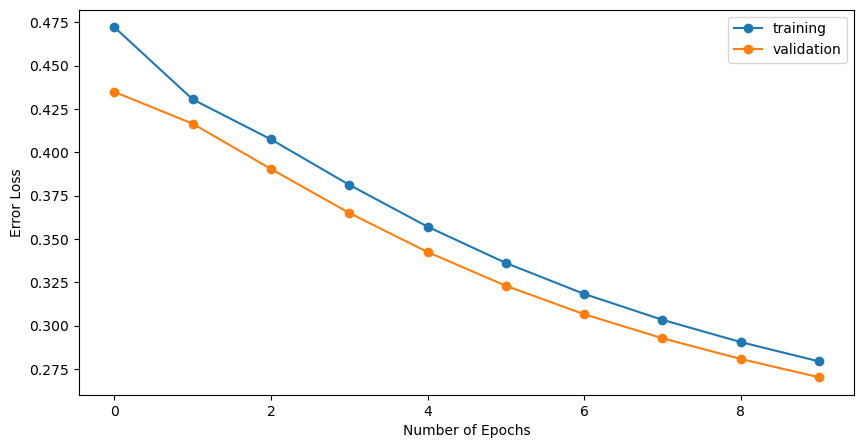

Trianing Recall Macro Curve


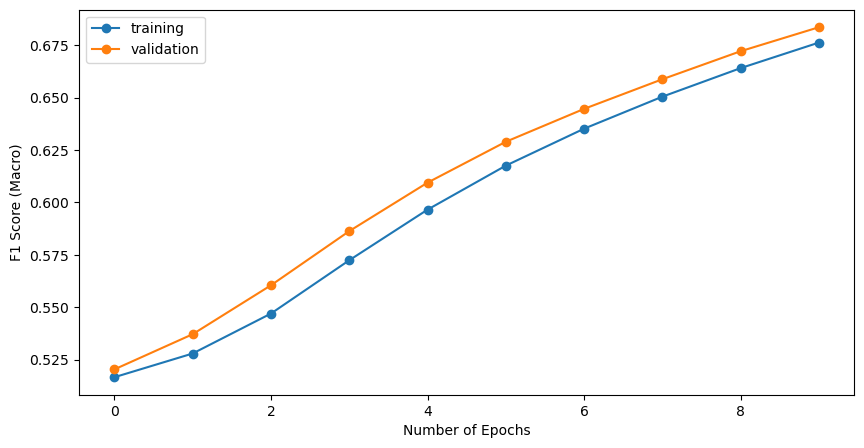

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.49      0.84      0.62      1645
  blue+whale       0.08      1.00      0.15       174
       sheep       0.74      0.81      0.77      1420
        seal       0.50      0.01      0.02       988
         bat       0.00      0.00      0.00       383
     giraffe       0.00      0.00      0.00      1202
         rat       0.52      0.71      0.60       310
      bobcat       0.71      0.97      0.82       630
      walrus       0.09      0.02      0.03       215
     dolphin       0.36      0.01      0.01       946

    accuracy                           0.45      7913
   macro avg       0.35      0.44      0.30      7913
weighted avg       0.42      0.45      0.36      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.84133739 1.         0.8084507  0.01012146 0.         0.
 0.70645161 0.97301587 0.01860465 0.00528541]
Top_1_accuracy for UnSeen Validation split 01 -  0.43632670970775145


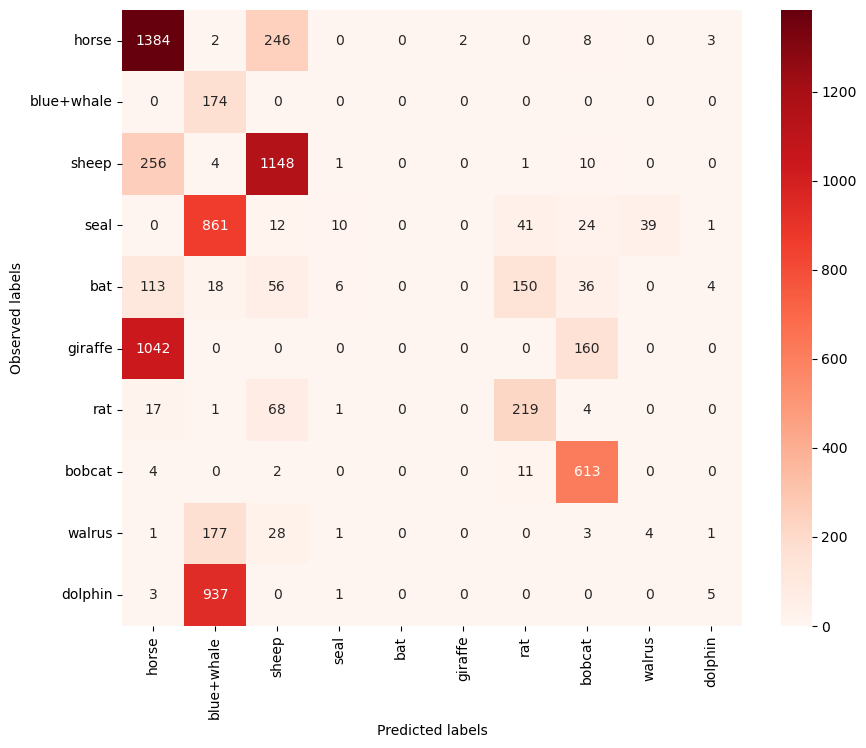

                precision    recall  f1-score   support

  ARTIODACTYLA       0.60      0.61      0.61      3742
     CARNIVORA       0.75      0.38      0.50      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       0.49      0.84      0.62      1645
      RODENTIA       0.52      0.71      0.60       310

      accuracy                           0.58      7913
     macro avg       0.47      0.51      0.47      7913
  weighted avg       0.58      0.58      0.56      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.606093   0.37861429 0.         0.84133739 0.70645161]
Top_1_accuracy for UnSeen Validation split 01 -  0.5064992581651906


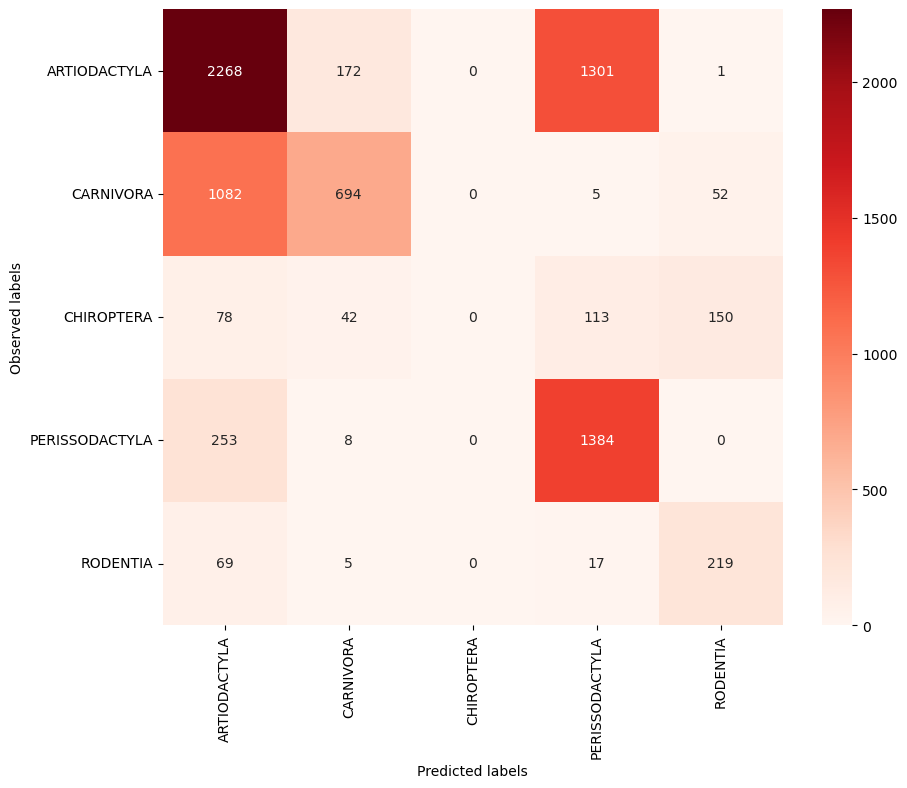

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.6243882474423318 
            0         1
0       horse  0.984802
1  blue+whale  1.000000
2       sheep  0.979577
3        seal  0.339069
4         bat  0.000000
5     giraffe  0.498336
6         rat  0.870968
7      bobcat  0.988889
8      walrus  0.404651
9     dolphin  0.177590 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.8237791430592771 
            0         1
0       horse  0.998784
1  blue+whale  1.000000
2       sheep  0.993662
3        seal  0.704453
4         bat  0.067885
5     giraffe  0.913478
6         rat  0.938710
7      bobcat  0.995238
8      walrus  0.660465
9     dolphin  0.965116 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.8704975130566559 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.996479
3        seal  0.906883
4         bat  0.127937
5     giraffe  0.953411
6         rat  0.948387
7      bobcat  0.996825
8      walrus  0.781395
9     dolphin  0.9

In [29]:
Test01 = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 10, 
               bs = 35, 
               numunits = 627, 
               lr = 0.010697267529081726, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2809510785718665, 
               mom = 0.9522309113527292, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard

 # 11. CZSL on Unseen Test Set using non optimised parameters

Training DNN
  epoch    train_loss    train_recall_macro    valid_loss    valid_recall_macro    cp     dur
-------  ------------  --------------------  ------------  --------------------  ----  ------
      1        0.4758                0.5161        0.4397                0.5179     +  1.4558
      2        0.4374                0.5210        0.4307                0.5231     +  1.4088
      3        0.4280                0.5278        0.4203                0.5332     +  1.3292
      4        0.4161                0.5377        0.4070                0.5441     +  1.3957
      5        0.4018                0.5503        0.3921                0.5574     +  1.3551
      6        0.3868                0.5652        0.3774                0.5729     +  1.3114
      7        0.3724                0.5798        0.3634                0.5871     +  1.3718
      8        0.3589                0.5933        0.3503                0.6003     +  1.3530
      9        0.3463                0.6060    

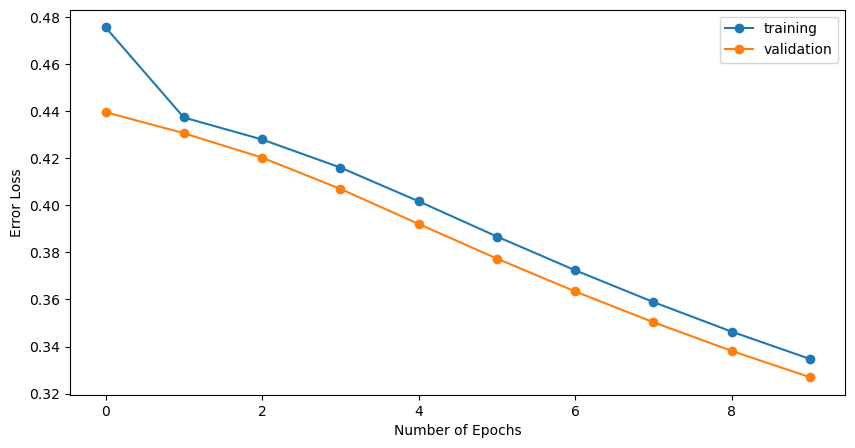

Trianing Recall Macro Curve


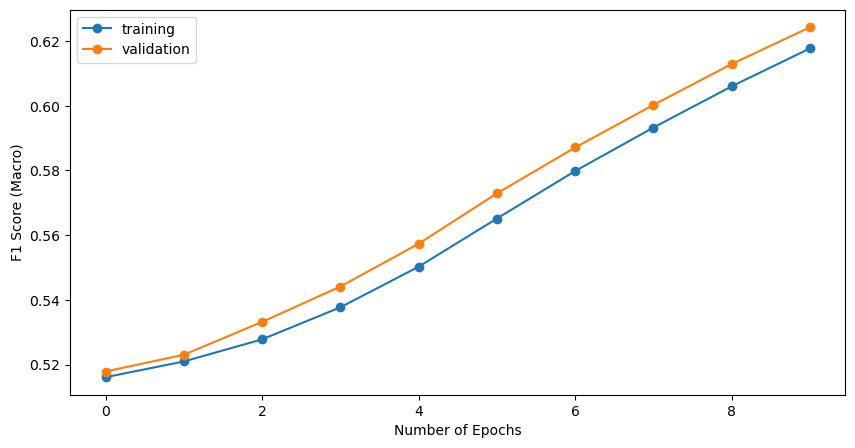

Unseen Class Labels
[ 7  9 23 24 30 31 34 41 47 50]
TSNE spatialisation of Unseen Classes


alt.LayerChart(...)

alt.LayerChart(...)

              precision    recall  f1-score   support

       horse       0.44      0.98      0.61      1645
  blue+whale       0.10      1.00      0.18       174
       sheep       0.72      0.49      0.59      1420
        seal       0.36      0.03      0.06       988
         bat       0.00      0.00      0.00       383
     giraffe       0.00      0.00      0.00      1202
         rat       0.50      0.88      0.64       310
      bobcat       0.70      0.97      0.81       630
      walrus       0.17      0.02      0.03       215
     dolphin       0.00      0.00      0.00       946

    accuracy                           0.43      7913
   macro avg       0.30      0.44      0.29      7913
weighted avg       0.35      0.43      0.33      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.9768997  1.         0.49366197 0.03238866 0.         0.
 0.88064516 0.97142857 0.01860465 0.        ]
Top_1_accuracy for UnSeen Validation split 01 -  0.43736287157289144


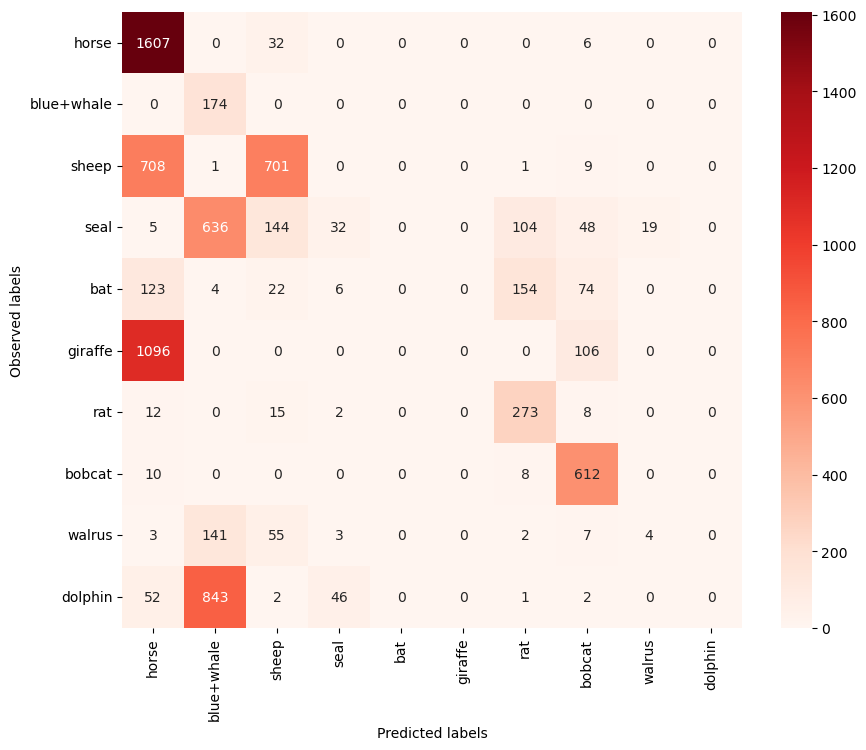

                precision    recall  f1-score   support

  ARTIODACTYLA       0.62      0.46      0.53      3742
     CARNIVORA       0.74      0.40      0.51      1833
    CHIROPTERA       0.00      0.00      0.00       383
PERISSODACTYLA       0.44      0.98      0.61      1645
      RODENTIA       0.50      0.88      0.64       310

      accuracy                           0.55      7913
     macro avg       0.46      0.54      0.46      7913
  weighted avg       0.58      0.55      0.52      7913

Top_1_accuracy for UnSeen Validation split 01 per class -  [0.45991448 0.39552646 0.         0.9768997  0.88064516]
Top_1_accuracy for UnSeen Validation split 01 -  0.5425971601856464


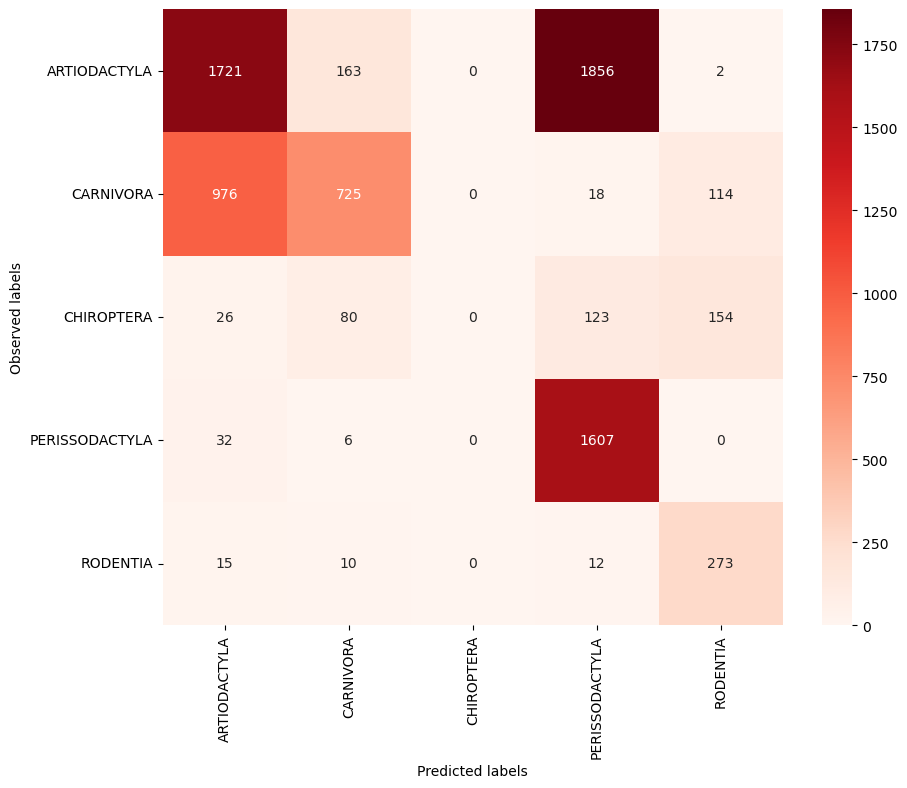

 Top- 2  Accuracy per class 
 Top- 2  Accuracy =  0.5843355469498523 
            0         1
0       horse  0.998784
1  blue+whale  1.000000
2       sheep  0.969718
3        seal  0.277328
4         bat  0.000000
5     giraffe  0.512479
6         rat  0.922581
7      bobcat  0.992063
8      walrus  0.153488
9     dolphin  0.016913 

 Top- 3  Accuracy per class 
 Top- 3  Accuracy =  0.7576534256056375 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  0.997183
3        seal  0.504049
4         bat  0.060052
5     giraffe  0.900166
6         rat  0.948387
7      bobcat  0.995238
8      walrus  0.386047
9     dolphin  0.785412 

 Top- 4  Accuracy per class 
 Top- 4  Accuracy =  0.818002746535249 
            0         1
0       horse  1.000000
1  blue+whale  1.000000
2       sheep  1.000000
3        seal  0.743927
4         bat  0.096606
5     giraffe  0.940100
6         rat  0.958065
7      bobcat  0.998413
8      walrus  0.534884
9     dolphin  0.90

In [28]:
Test02 = CZSL(mode = "Test", 
               split = 3, 
               DNN = ProjectionNetwork1, 
               epochs = 10, 
               bs = 32, 
               numunits = 1024, 
               lr = 0.1, 
               optimiser = nn.Sigmoid(), 
               dropout = 0.2, 
               mom = 0, 
               wd = 0,  
               device = 'cuda', 
               checkpoint = CP_final, 
               pred_type = 'Probabilistic', 
               dist_type = 'cosine')

#mode
#1. "Train" - Use Train Val split
#2. "Test" - For Unseen Test Data

#split
# 1 -Train/Val Split 1
# 2 -Train/Val Split 2
# 3 -Train/Val Split 3

#pred_type
#1. "Probabilistic" - continous real numbers giving probability for prdiction to be 1
#2. "Deterministic" - 1 or 0 prediction values

#dist_type
#1. euclidean
#2. cosine
#3. hamming
#4. jaccard